In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.dpi'] = 200

data = pd.read_csv('OnlineNewsPopularity_ForModeling.csv',index_col='url')
data = data.drop(index='http://mashable.com/2014/08/18/ukraine-civilian-convoy-attacked/')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39643 entries, http://mashable.com/2013/01/07/amazon-instant-video-browser/ to http://mashable.com/2014/12/27/youtube-channels-2015/
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                39643 non-null  float64
 1   n_tokens_content              39643 non-null  float64
 2   n_unique_tokens               39643 non-null  float64
 3   n_non_stop_words              39643 non-null  float64
 4   n_non_stop_unique_tokens      39643 non-null  float64
 5   num_hrefs                     39643 non-null  float64
 6   num_self_hrefs                39643 non-null  float64
 7   num_imgs                      39643 non-null  float64
 8   num_videos                    39643 non-null  float64
 9   average_token_length          39643 non-null  float64
 10  num_keywords                  39643 non-null  float64
 11  kw_min_min       

In [2]:
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def Random_Forest_Model(model_data, y_var,best_depth=None,cm=True,roc=False):
    """
    Quickly makes a Random Forest Model, provides accuracy scores and provides confusion matrix 
    unless specified otherwise. Allow for the specification of depth.
    """
    # use the selected y_var to seperate the X and Y variables
    y_var_values = model_data[y_var].unique()
    X = model_data.drop(columns=y_var)
    y = model_data[y_var].replace(y_var_values,range(len(y_var_values)))
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,stratify=y)
    
    # make model
    scaler = StandardScaler()
    random_forest = RandomForestClassifier(max_depth=best_depth)
    pipe = make_pipeline(scaler,random_forest)
    
    # fit model and predict
    pipe.fit(X_train,y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    
    # print accuracy score
    print('training accuracy:',accuracy_score(y_train, y_pred_train))
    print('test accuracy:',accuracy_score(y_test, y_pred_test))
    
    # if cm == True, plot the confusion matrix
    if cm == True:
        cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
        cnf_matrix_train = confusion_matrix(y_train, y_pred_train)
        
        plt.figure(figsize=(12,6),dpi=200)
        plt.subplot(121)
        plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')
        plt.subplot(122)
        plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')
        
    # if roc == True, plot the roc curve
    if roc == True:
        y_pred_train_proba = pipe.predict_proba(X_train)[:, 1]
        y_pred_test_proba = pipe.predict_proba(X_test)[:, 1]
        fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)
        
        plt.figure(figsize=(12,6),dpi=200)
        plt.subplot(121)
        plt.title('Train ROC')
        plt.plot(fpr_train, tpr_train)
        plt.subplot(122)
        plt.title('Test ROC')
        plt.plot(fpr_test, tpr_test)
    
    #returns the pipeline
    return pipe

# Random Forest Model
Start by making a model

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Three Brackets
For simplicity, I tried seperating the entries into three seperate brackets based on percentiles

training accuracy: 0.9180900900900901
test accuracy: 0.6193559236525688


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

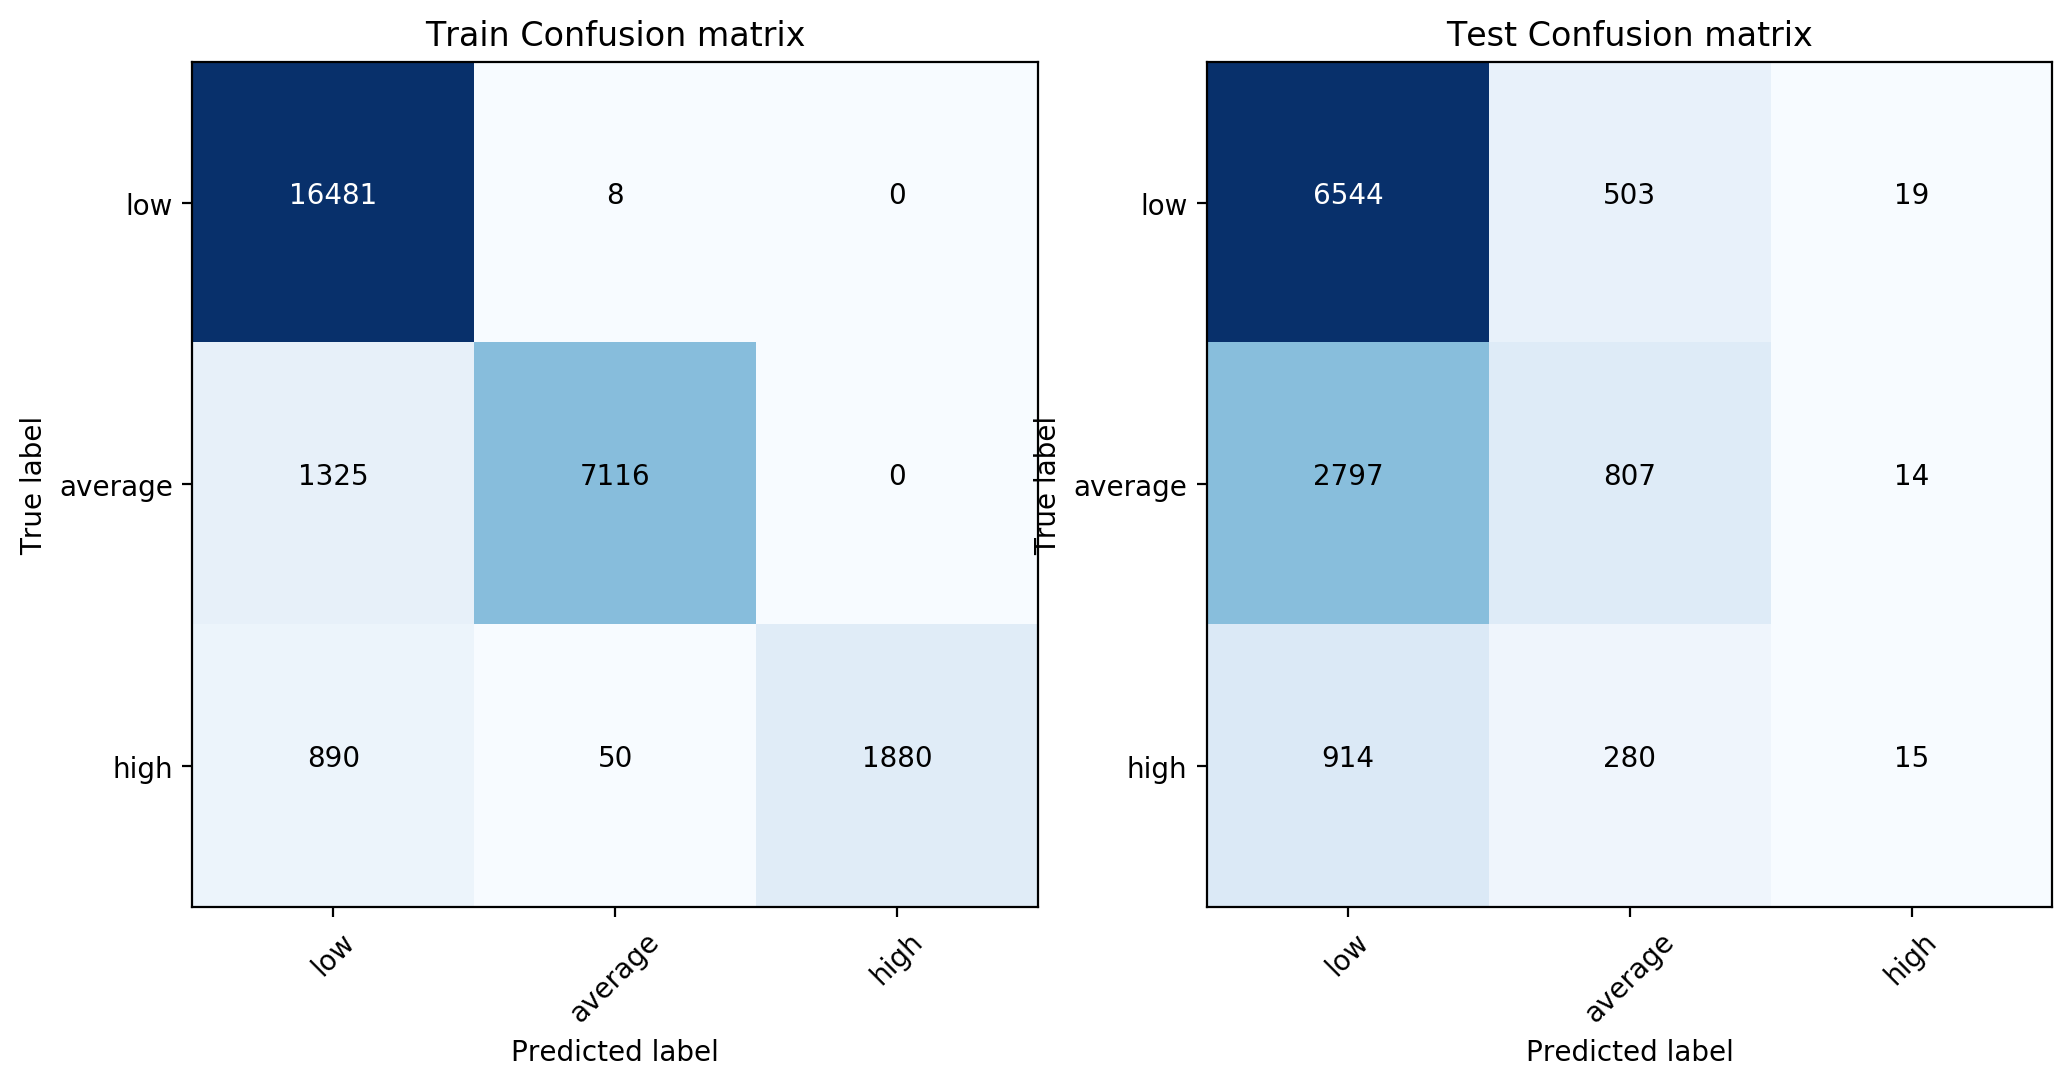

In [4]:
model_data_1 = data.copy()

avg = int(np.percentile(model_data_1.shares,[0,60])[1])
high = int(np.percentile(model_data_1.shares,[0,90])[1])

# Seperate entries into three categories
index = model_data_1[model_data_1.shares < avg].index
model_data_1.loc[index,'category'] = 'low'

index = model_data_1[(model_data_1.shares >= avg) & (model_data_1.shares < high)].index
model_data_1.loc[index,'category'] = 'average'

index = model_data_1[model_data_1.shares >= high].index
model_data_1.loc[index,'category'] = 'high'

# Appends together
model_data_1 = model_data_1.drop(columns='shares')

Random_Forest_Model(model_data_1,'category',best_depth=15)

Not a very good model its seem. Its misclassifing alot of entries as `low`, probably since there are too many entries in that catergory. So I'll try limiting the amount of entries so that there is an equal amount of all of them

training accuracy: 0.997872340425532
test accuracy: 0.48469809760132343


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

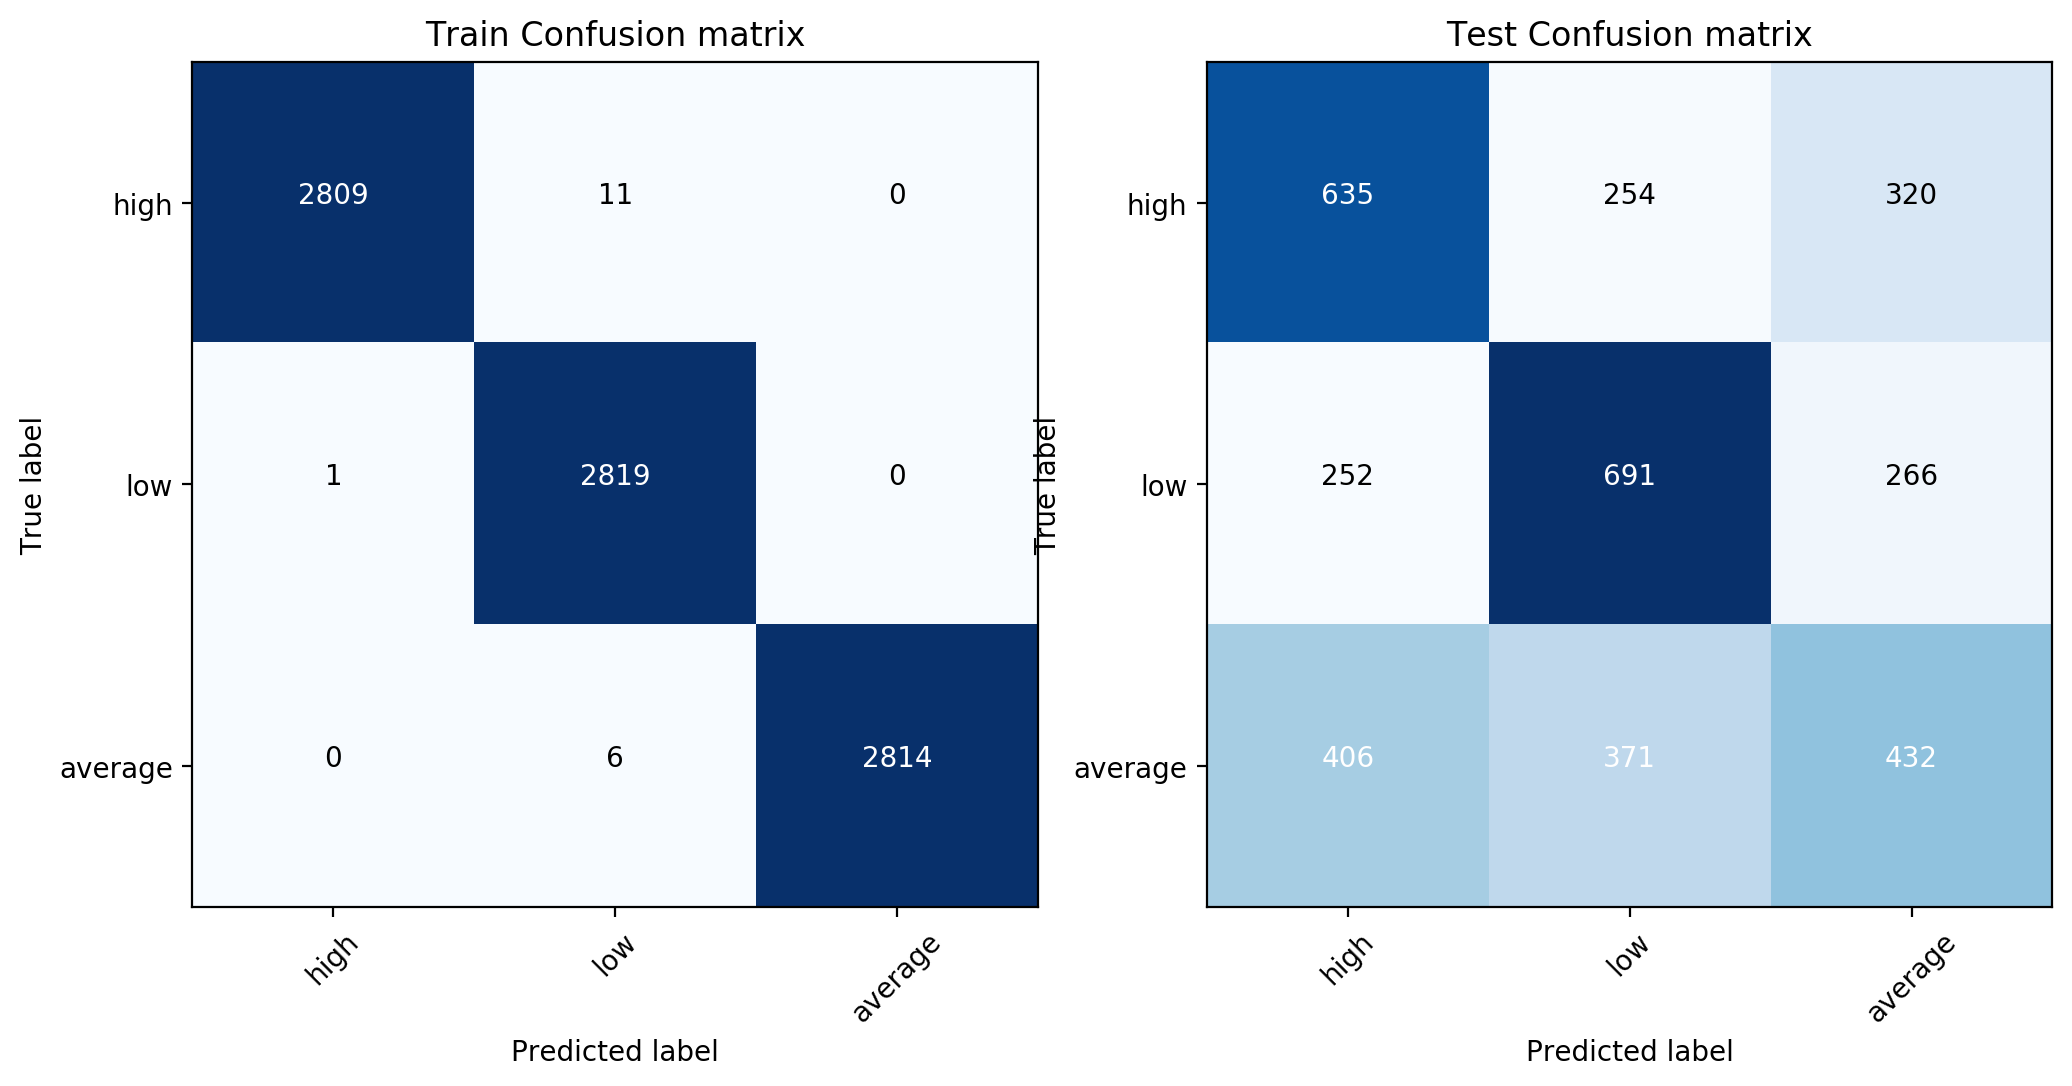

In [5]:
def lim_entries(data,column,both=False):
    '''
    Takes a dataframe and a selected column and equalizes the distribution.
    '''
    entries = list(data[column].value_counts().index[:-1])
    n = list(data[column].value_counts())[-1]
    new = data.loc[data[column] == data[column].value_counts().index[-1]]
    
    for entry in entries:
        selected = data[data[column] == entry].reset_index()
        selected_col = selected.columns
        index = selected_col[0]
        selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
        new = new.append(selected)  
    if both == True:
        new = [new,data.drop(index=list(new.index))]
    return new

model_data_1 = lim_entries(model_data_1,'category')
Random_Forest_Model(model_data_1,'category',best_depth=15)

Accuracy went down, but the confusion matrix shows a better distribution.

# Popularity
Split entries into popular and unpopular

training accuracy: 1.0
test accuracy: 0.6527196652719666


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=13, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

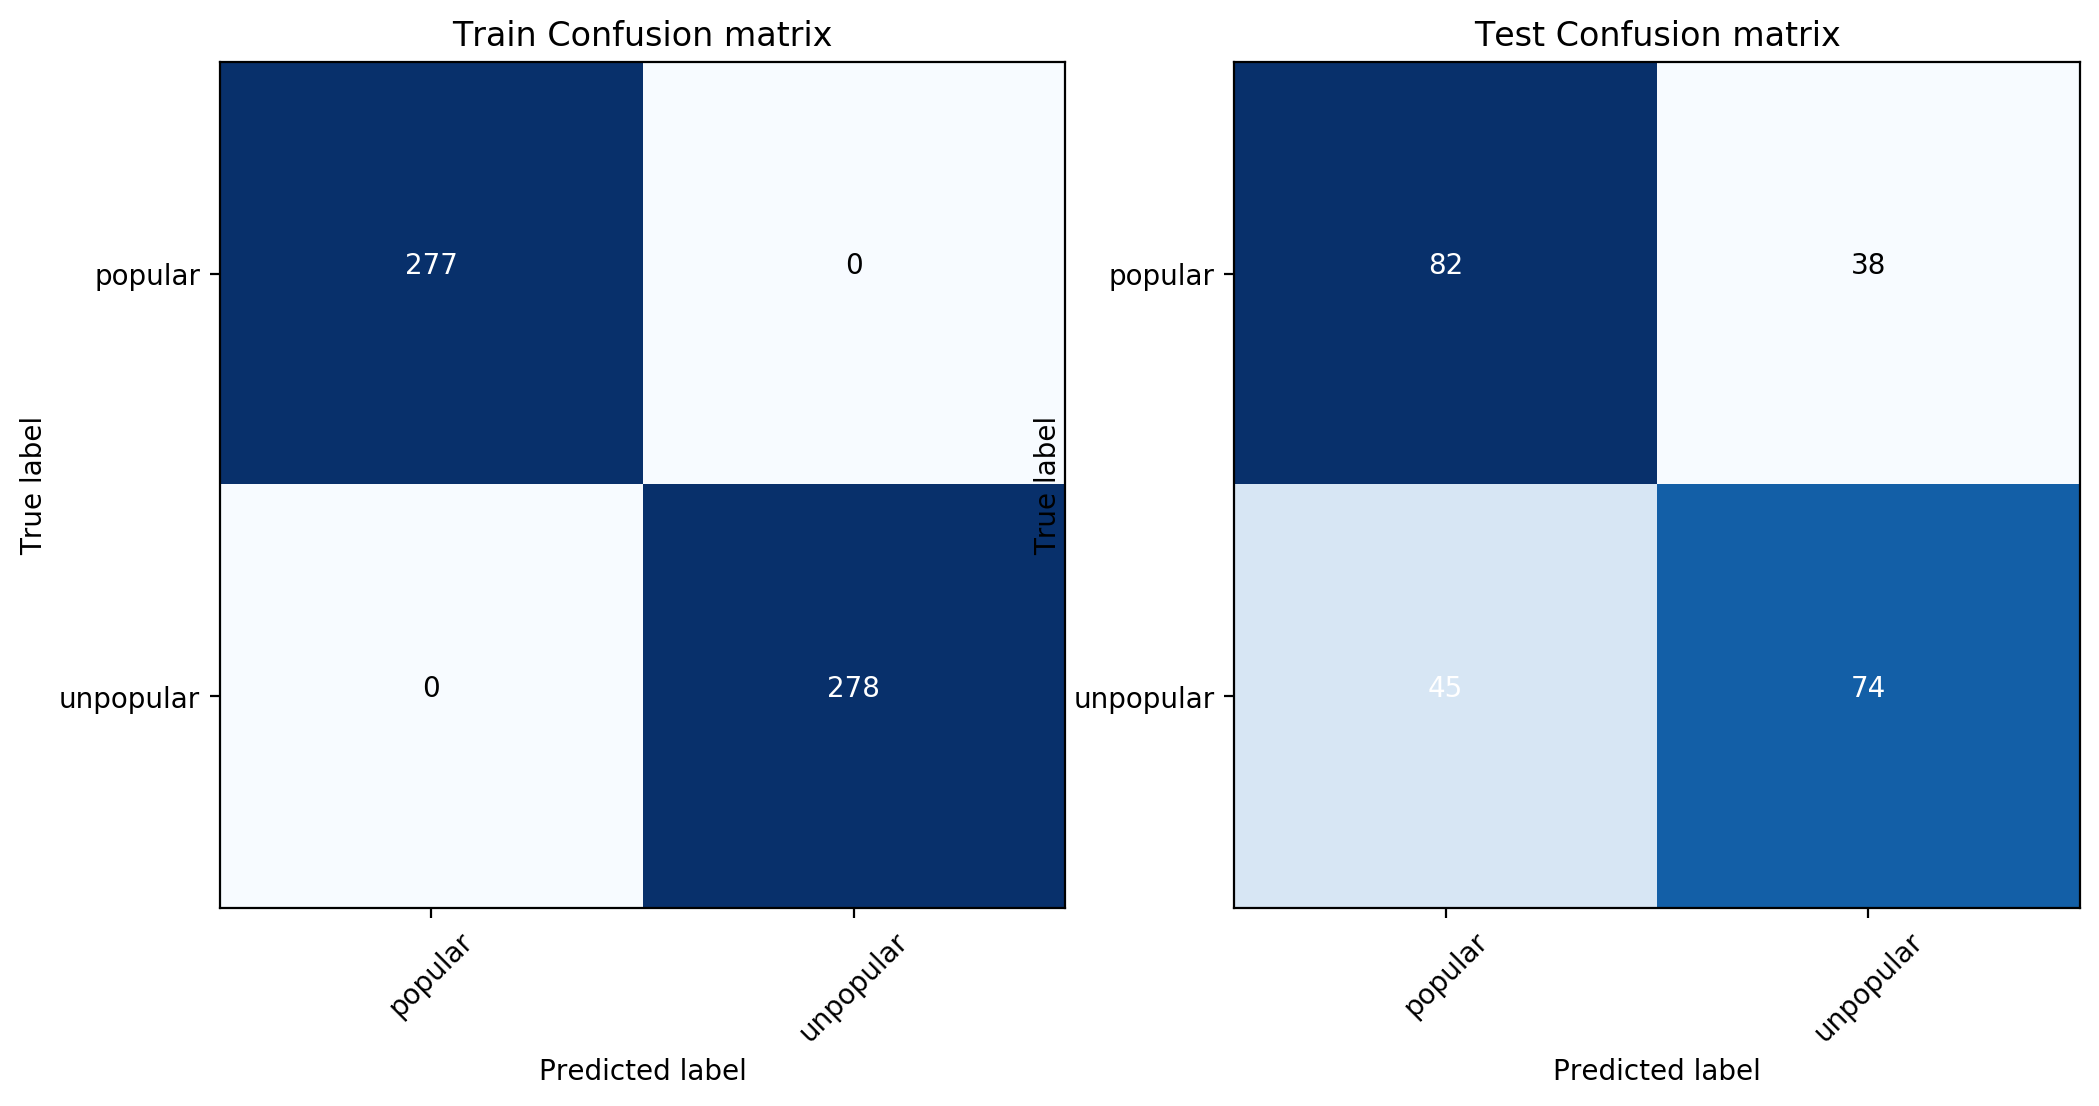

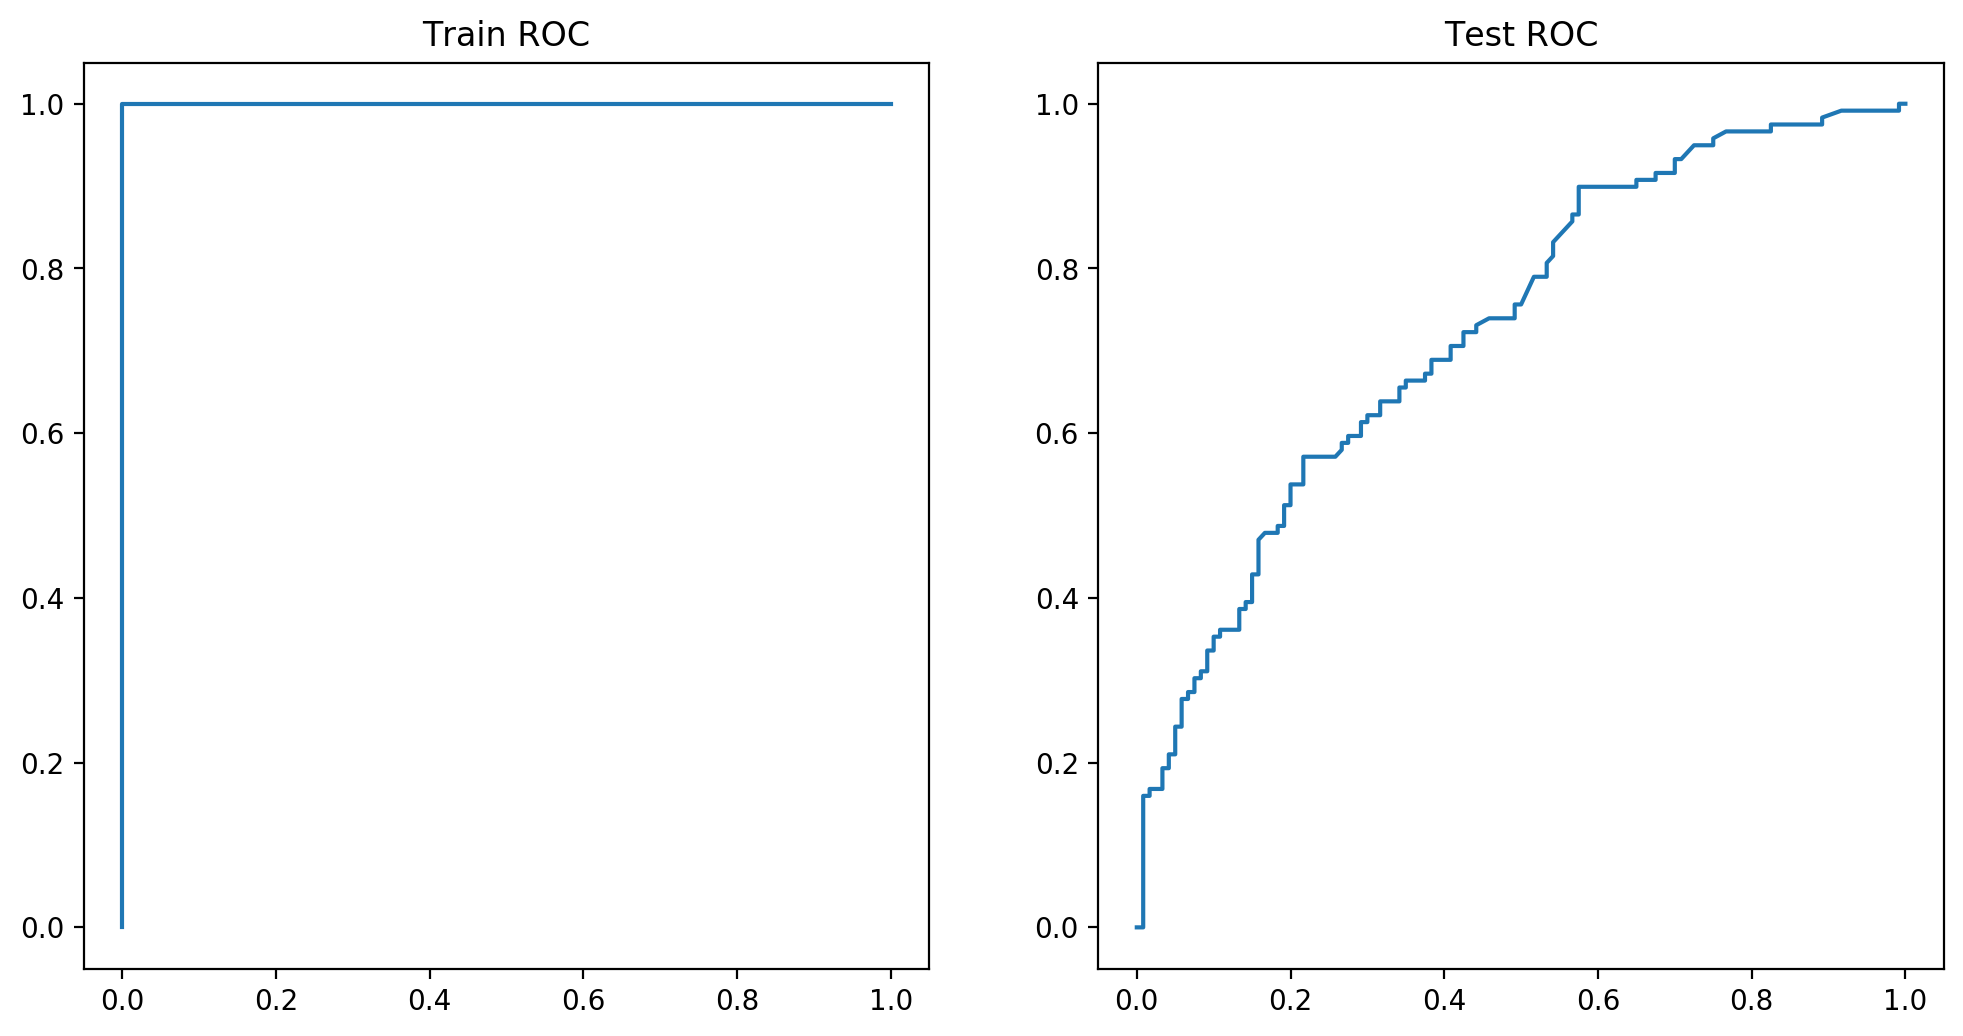

In [6]:
model_data_2 = data.copy()
pop = np.percentile(model_data_2.shares,[0,99])[1]

# Seperate entries into two categories
popular = model_data_2[(model_data_2.shares > pop)].index
model_data_2.loc[popular,'category'] = 'popular'

unpopular = model_data_2[model_data_2.shares <= pop].index
model_data_2.loc[unpopular,'category'] = 'unpopular'

model_data_2 = model_data_2.drop(columns='shares')

# Limit the amount of entries
model_data_2 = lim_entries(model_data_2,'category')

# Model
Random_Forest_Model(model_data_2,'category',best_depth=13,roc=True)

It seems this model works better, so for ease I'll make it a definition

In [7]:
def model_popularity(data):
    pop_thresh = np.percentile(data.shares,[0,90])[1]
    data.assign(category=np.nan)

    popular = data[(data.shares > pop_thresh)].index
    data.loc[popular,'category'] = 'popular'

    unpopular = data[data.shares <= pop_thresh].index
    data.loc[unpopular,'category'] = 'unpopular'

    data = data.drop(columns='shares')

    data = lim_entries(data,'category')
    
    return data

# K Means Clustering

In [8]:
from sklearn.cluster import KMeans

Start by finding the best amount of clusters for the model

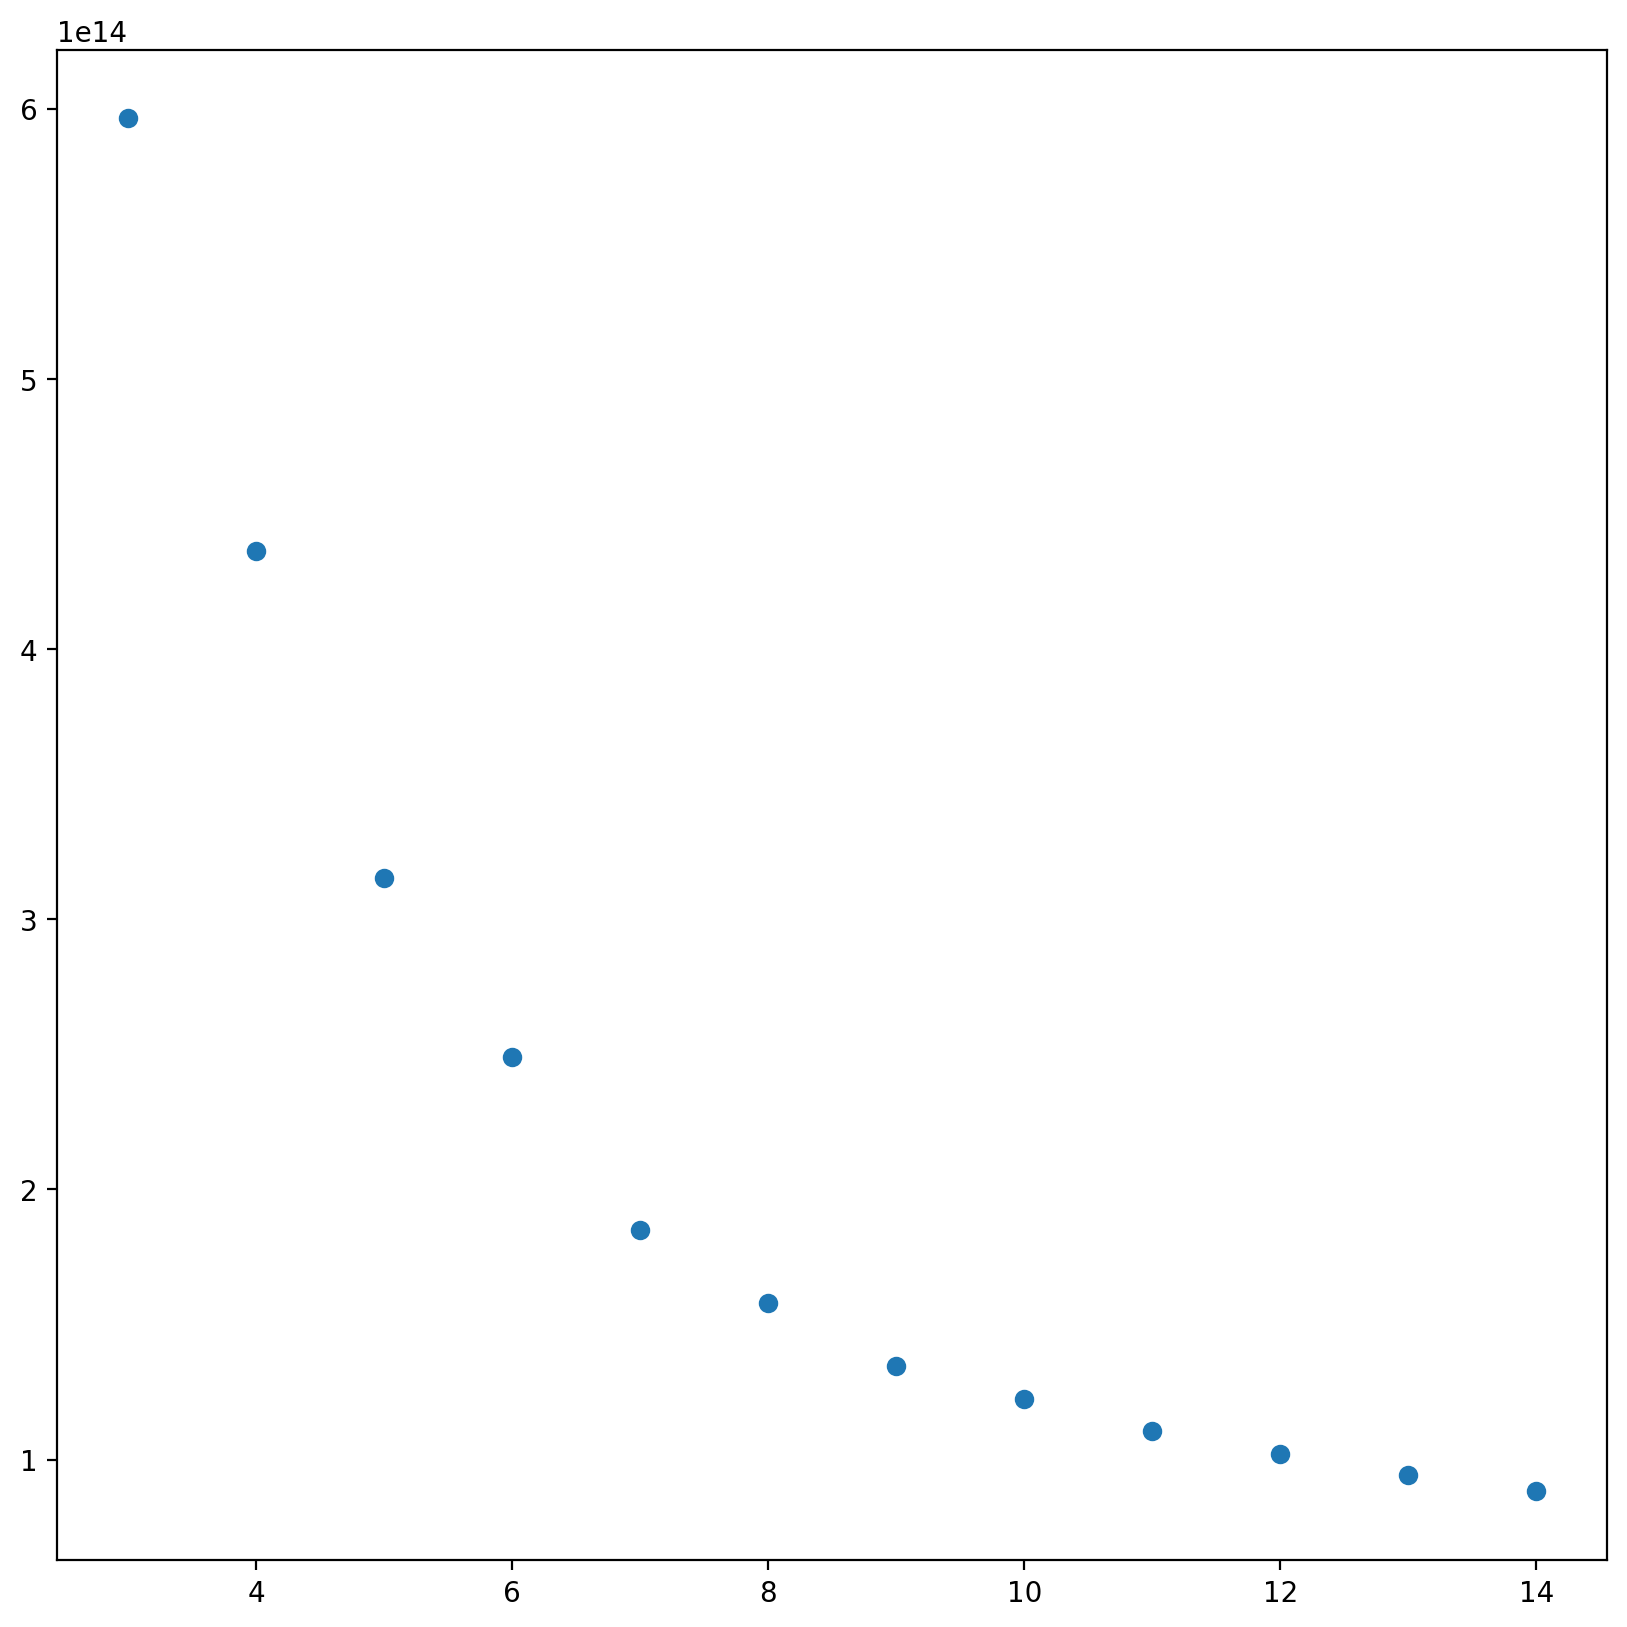

In [9]:
model_data_km = data.copy()

K_range = range(3,15)
inertia = []

for k in K_range:
    scaler = StandardScaler()
    scaler.fit(model_data_km)
    scaler.transform(model_data_km)
    model = KMeans(n_clusters=k)
    model.fit(model_data_km)
    inertia.append(model.inertia_)

plt.scatter(K_range,inertia)

Seven looks like a good 'elbow' point, so I'll use seven clusters

In [10]:
model_data_km = data.copy()

X_km = model_data_km.drop(columns='shares')
k = 7

scalar = StandardScaler()
model = KMeans(n_clusters=k)
pipe = make_pipeline(scalar, model)
pipe.fit(X_km)

label=pipe.predict(X_km)

model_data_km['label'] = label

model_data_km.label.value_counts()

3    14718
1    11298
5     8037
2     4345
4     1180
0       40
6       25
Name: label, dtype: int64

So after runnning the model a couple times, the same article aways gets its own label. It seems that despite having text, all the text related columns are 0, not to mentaion that self_reference_max_shares is less self_reference_min_shares. This must be an error so Ill remove it from the data.

In [25]:
def plot_hist(column):
    for label in model_data_km.label.unique():
        plt.hist(model_data_km[model_data_km.label==label][column],label=('cluster '+str(label)),alpha=0.3)
    plt.title(column)

In [35]:
plt.figure(figsize=(20,30),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
for n,col_name in enumerate(model_data_km.columns[:-14],start=1):
    plt.subplot(11,4,n)
    plot_hist(col_name)
plt.legend(bbox_to_anchor=(-.3,-.3),ncol=7)

From what i can gather from these histograms...
 - Cluster 1 has higher LDA_02
 - Cluster 2 has high kw_min_min and low kw_max_max
 - Cluster 3 has higher LDA_04
 - Cluster 4 has no text 
 - Cluster 5 has more media (images, video) and higher LDA_03

# PCA

In [14]:
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

data_pca = model_data_km.copy()

X_pca = data_pca.drop(columns=['shares'])

# Create PCA instance: model
scalar = StandardScaler()
model = PCA()

pca_pipe = make_pipeline(scaler,model)

# Apply the fit_transform method of model to grains: pca_features
pca_features = pca_pipe.fit_transform(X_pca)
features = pd.DataFrame({'features':range(0,model.n_components_),'varience':model.explained_variance_}).set_index('features')
pca_features = pd.DataFrame(pca_features)

# Set the variance threshold to select only top components
thresh = 2

# Plot the explained variances
plt.figure(figsize=(20,5))
plt.axhline(y=thresh,linestyle='--',c='r')
plt.bar(features.index,features.varience )
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features.index)
plt.show()

In [15]:
# attach labels to pca components
pca_features['label'] = data_pca.label.values
pca_features['shares'] = data_pca.shares.values

# use thresh to select only the higher varience components
columns_drop = list(features[features.varience < thresh].index)
pca_features = pca_features.drop(columns = columns_drop)

# Plot
sns.pairplot(data=pca_features,hue='label',plot_kws=dict(alpha=0.2));

When it comes to PCA...
 - Cluster 3 seems to have higher values for Components 5 & 6
 - Cluster 4 seems to have higher values for Component 0.
 - Cluster 0 has a higher spread and there seems to be a linear relationship between the components.
 
 Lets see if using the pca components help the accuracy of the model.

In [16]:
model_data_5 = pca_features.copy()
model_data_5 = model_popularity(model_data_5)
Random_Forest_Model(model_data_5,'category',best_depth=13)

training accuracy: 0.9328385228095583
test accuracy: 0.6511824324324325


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=13, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

Doesn't seem like this helps the accuracy, overall the best model is the original, Popular v Unpopular model.